In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
data = pd.read_csv('../data/csv_data/data/dataCOVID19_es.csv')

In [31]:
poblacion_edades = pd.read_csv('../data/info_data/población_edades.csv')
death_rate = pd.read_csv('../data/info_data/death_rate.csv')

In [35]:
death_rate

,AGE,DEATH_RATE(%)
0,80+ years old,14.8
1,70-79 years old,8.0
2,60-69 years old,3.6
3,50-59 years old,1.3
4,40-49 years old,0.4
5,30-39 years old,0.2
6,20-29 years old,0.2
7,10-19 years old,0.2
8,0-9 years old,0.0


In [40]:
poblacion_edades.loc[poblacion_edades.Comunidades == 'España'][16:].Total.sum()

2864519

In [8]:
Spain = data.groupby('fecha', as_index=False).sum()

Spain['nuevos_casos'] = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

Spain

,fecha,casos,IA,UCI,muertes,nuevos_casos
0,2020-03-02,114.0,0.00,0.0,0.0,NaN
1,2020-03-03,150.0,6.63,0.0,0.0,36.0
2,2020-03-04,198.0,9.55,7.0,1.0,48.0
3,2020-03-05,237.0,11.76,9.0,3.0,39.0
4,2020-03-06,365.0,20.55,11.0,5.0,128.0
5,2020-03-07,577.0,30.80,29.0,8.0,212.0
6,2020-03-08,787.0,41.04,50.0,13.0,210.0
7,2020-03-09,999.0,51.29,68.0,16.0,212.0
8,2020-03-10,1622.0,87.11,100.0,35.0,623.0
9,2020-03-11,2128.0,114.39,142.0,47.0,506.0


In [15]:
class SEIR:
    """
    'eons' (number of time points to model, default 1000)
    'Susceptible' (number of susceptible individuals at time 0, default 950)
    'Exposed' (number of individuals during incubation period)
    'Infected' (number of infected individuals at time 0, default 50)
    'Resistant' (number of resistant individuals at time 0, default 0)
    'rateSI' (base rate 'beta' from S to E, default 0.05)
    'rateIR' (base rate 'gamma' from I to R, default 0.01)
    'rateAl' (base rate of isolation 'altha', from E to I, default 0.1)
    """
    def __init__(self, eons=1000, Susceptible=950, Exposed = 100, Infected=50, Resistant=0, rateSI=2.3, rateIR=1/14., rateAl = 0.1):
        self.eons = eons
        self.Susceptible = Susceptible
        self.Exposed = Exposed
        self.Infected = Infected
        self.Resistant = Resistant
        self.rateSI = rateSI
        self.rateIR = rateIR
        self.rateAl = rateAl
        self.numIndividuals = Susceptible + Infected + Resistant + Exposed # total population
        self.results = None
        self.modelRun = False

    def run(self, death_rate):
        Susceptible = [self.Susceptible]
        Exposed = [self.Exposed]
        Infected = [self.Infected]
        Resistant = [self.Resistant]

        for step in range(1, self.eons):
            S_to_E = (self.rateSI * Susceptible[-1] * Infected[-1]) / self.numIndividuals
            E_to_I = (self.rateAl * Exposed[-1])
            I_to_R = (Infected[-1] * self.rateIR)
            
            Susceptible.append(Susceptible[-1] - S_to_E)
            Exposed.append(Exposed[-1] + S_to_E - E_to_I)
            Infected.append(Infected[-1] + E_to_I - I_to_R)
            Resistant.append(Resistant[-1] + I_to_R)
        
        # Death is death_rate* recovery group
        Death = list(map(lambda x: (x * death_rate), Resistant))
        # Heal is removed - Death
        Heal = list(map(lambda x: (x * (1-death_rate)), Resistant))
        self.results = pd.DataFrame.from_dict({'Time':list(range(len(Susceptible))),
            'Susceptible':Susceptible, 'Exposed': Exposed, 'Infected':Infected, 'Resistant':Resistant,
                                               'Death':Death, 'Heal': Heal},
            orient='index').transpose()
        self.modelRun = True
        return self.results

    def plot(self, title, ylabel, xlabel):
        if self.modelRun == False:
            print('Error: Model has not run. Please call SIR.run()')
            return
        print("Maximum infected case: ",
              format(int(max(self.results['Infected']))))
        fig, ax = plt.subplots(figsize=(20,12))
        plt.plot(self.results['Time'], self.results['Susceptible'], color='blue')
        plt.plot(self.results['Time'], self.results['Infected'], color='red')
        plt.plot(self.results['Time'], self.results['Exposed'], color='orange')
        plt.plot(self.results['Time'], self.results['Resistant'], color='palegreen')
        plt.plot(self.results['Time'], self.results['Heal'], color='green')
        plt.plot(self.results['Time'], self.results['Death'], color='grey')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Susceptible','Infected','Exposed','Removed', 'Heal', 'Death'], prop={'size': 12}, bbox_to_anchor=(0.5, 1.02), ncol=6, fancybox=True, shadow=True)
        plt.title(title, fontsize = 20)
        plt.show()
        
    def plot_noSuscep(self, title, ylabel, xlabel):
        if self.modelRun == False:
            print('Error: Model has not run. Please call SIR.run()')
            return
        print("Maximum infected case: ",
              format(int(max(self.results['Infected']))))
        fig, ax = plt.subplots(figsize=(20,12))
        plt.plot(self.results['Time'], self.results['Infected'], color='red')
        plt.plot(self.results['Time'], self.results['Resistant'], color='palegreen')
        plt.plot(self.results['Time'], self.results['Exposed'], color='orange')
        plt.plot(self.results['Time'], self.results['Heal'], color='green')
        plt.plot(self.results['Time'], self.results['Death'], color='grey')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['Infected','Removed','Exposed','Heal','Death'], prop={'size': 12}, bbox_to_anchor=(0.5, 1.02), ncol=5, fancybox=True, shadow=True)
        plt.title(title, fontsize = 20)
        plt.show()

In [45]:
model = SEIR(eons=90, Susceptible=2864519, 
             Exposed = 500, Infected=40, Resistant=0, 
             rateSI=1.5, rateIR=1/14., rateAl = 0.4)

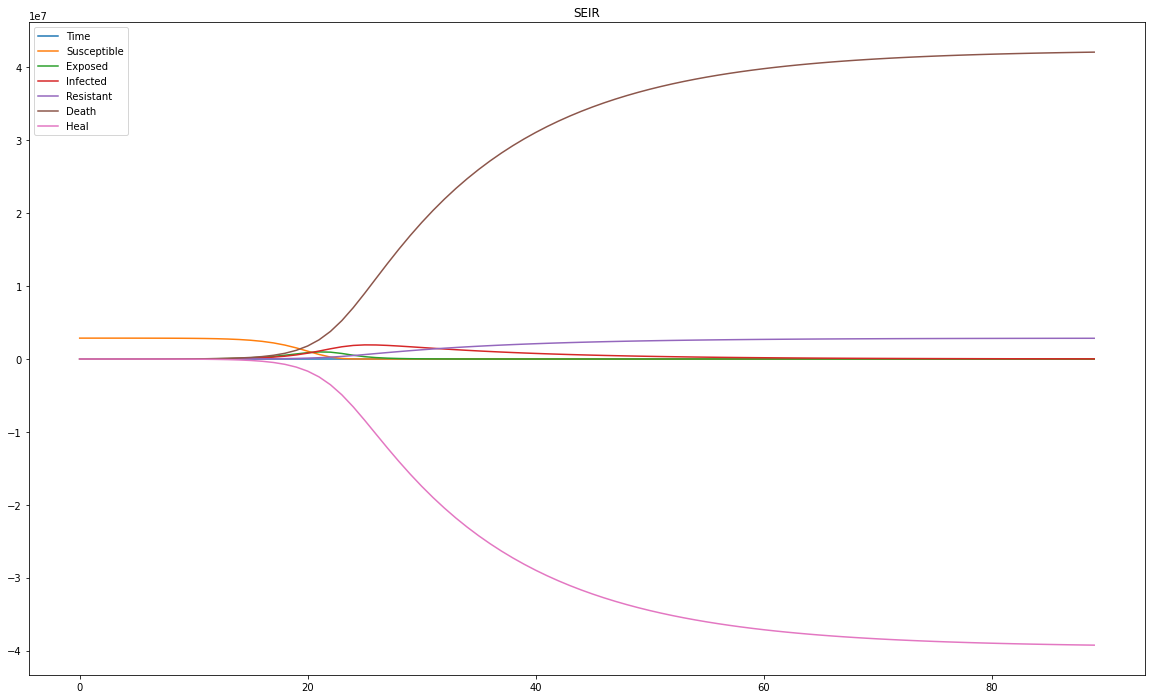

In [46]:
model.run(14.8).plot(title='SEIR',figsize=(20,12));

Maximum infected case:  1936432


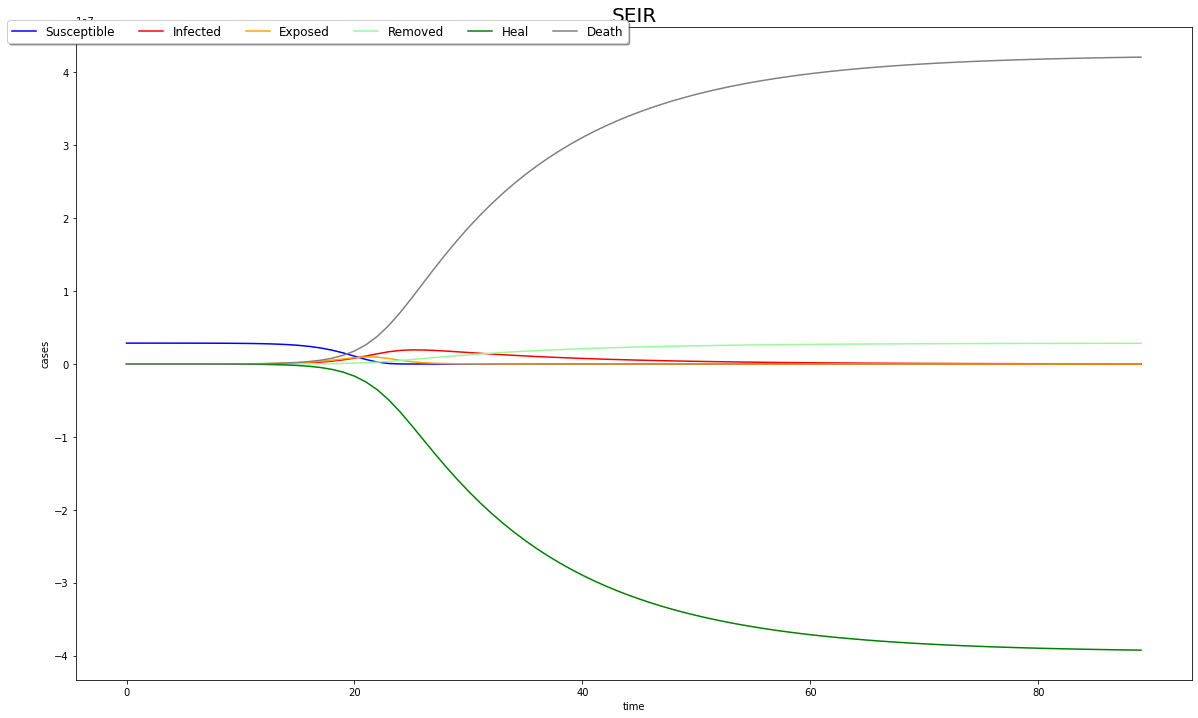

In [47]:
model.plot(title='SEIR', ylabel='cases', xlabel='time')